In [8]:
import concurrent.futures

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from virtual_lab.agent import Agent
from virtual_lab.constants import CONSISTENT_TEMPERATURE, CREATIVE_TEMPERATURE
from virtual_lab.prompts import create_merge_prompt
from virtual_lab.run_meeting import run_meeting
from virtual_lab.utils import load_summaries

from nanobody_constants import (
    background_prompt,
    nanobody_prompt,
    discussions_phase_to_dir,
    generic_team_lead,
    generic_team,
    principal_investigator,
    immunologist,
    team_members,
    num_rounds,
    num_iterations,
)

## Setup

In [2]:
ablations_dir = discussions_phase_to_dir["ablations"]
ablations_dir.mkdir(parents=True, exist_ok=True)

## Generic vs specialized agent

Compare a team of generic agents to a team of specialized agents. For the generic team discussions, see below. For the specialized team discussions, see `discussions/project_specification`.

In [7]:
# Project specification - prompts
project_specification_agenda = f"{background_prompt} Please create an antibody/nanobody design approach to solve this problem. Decide whether you will design antibodies or nanobodies. For your choice, decide whether you will design the antibodies/nanobodies de novo or whether you will modify existing antibodies/nanobodies. If modifying existing antibodies/nanobodies, please specify which antibodies/nanobodies to start with as good candidates for targeting the newest variant of the SARS-CoV-2 spike protein. If designing antibodies/nanobodies de novo, please describe how you will propose antibody/nanobody candidates."

project_specification_questions = (
    "Will you design standard antibodies or nanobodies?",
    "Will you design antibodies/nanobodies de novo or will you modify existing antibodies/nanobodies (choose only one)?",
    "If modifying existing antibodies/nanobodies, which precise antibodies/nanobodies will you modify (please list 3-4)?",
    "If designing antibodies/nanobodies de novo, how exactly will you propose antibody/nanobody candidates?",
)

project_specification_dir = ablations_dir / "project_specification"
project_specification_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Project specification - discussion
with concurrent.futures.ThreadPoolExecutor() as executor:
    concurrent.futures.wait([
        executor.submit(
            run_meeting,
            meeting_type="team",
            team_lead=generic_team_lead,
            team_members=generic_team,
            agenda=project_specification_agenda,
            agenda_questions=project_specification_questions,
            save_dir=project_specification_dir,
            save_name=f"discussion_{iteration_num + 1}",
            temperature=CREATIVE_TEMPERATURE,
            num_rounds=num_rounds,
        ) for iteration_num in range(num_iterations)
    ])

In [ ]:
# Project specification - merge
project_specification_summaries = load_summaries(
    discussion_paths=list(project_specification_dir.glob("discussion_*.json")))
print(f"Number of summaries: {len(project_specification_summaries)}")

project_specification_merge_prompt = create_merge_prompt(
    agenda=project_specification_agenda,
    agenda_questions=project_specification_questions,
)

run_meeting(
    meeting_type="individual",
    team_member=generic_team_lead,
    summaries=project_specification_summaries,
    agenda=project_specification_merge_prompt,
    save_dir=project_specification_dir,
    save_name="merged",
    temperature=CONSISTENT_TEMPERATURE,
    num_rounds=num_rounds,
)

## Specialized vs finetuned agent

### Question and Answer

See `finetune_agents.ipynb` for the question and answer pairs and evaluation.

### Knowledge

Compare the knowledge of a specialized agent (Immunologist) and a finetuned agent (Immunologist-FT).

In [3]:
immunologist_ft = Agent(
    title=immunologist.title,
    expertise=immunologist.expertise,
    goal=immunologist.goal,
    role=immunologist.role,
    model="ft:gpt-4o-mini-2024-07-18:personal:sars-cov-2-variants-kp-3-and-jn-1:AzeSvPAe",
)

In [ ]:
agenda = "What are some of the RBD mutations of the KP.3 and JN.1 variants of the SARS-CoV-2 spike protein?"

agents_names = [
    (immunologist, "immunologist"),
    (immunologist_ft, "immunologist_ft"),
]

for agent, agent_name in agents_names:
    run_meeting(
        meeting_type="individual", 
        team_member=agent,
        agenda=agenda,
        save_dir=ablations_dir,
        save_name=f"knowledge_{agent_name}",
        temperature=CONSISTENT_TEMPERATURE,
    )

## Single vs multi agent

Look at `discussions/alphafold/discussion_4.md` to compare the effect of a single agent vs a multi-agent interaction. The first round answer is the product of just a single specialized agent (Computational Biologist) while the final round answer is the product of the multi-agent interaction (Computational Biologist and Scientific Critic).

Also, see below for a human analysis of the effects of single agent vs multi-agent interactions for coding.

In [7]:
coding_eval = pd.read_csv(ablations_dir / "coding_eval.csv")

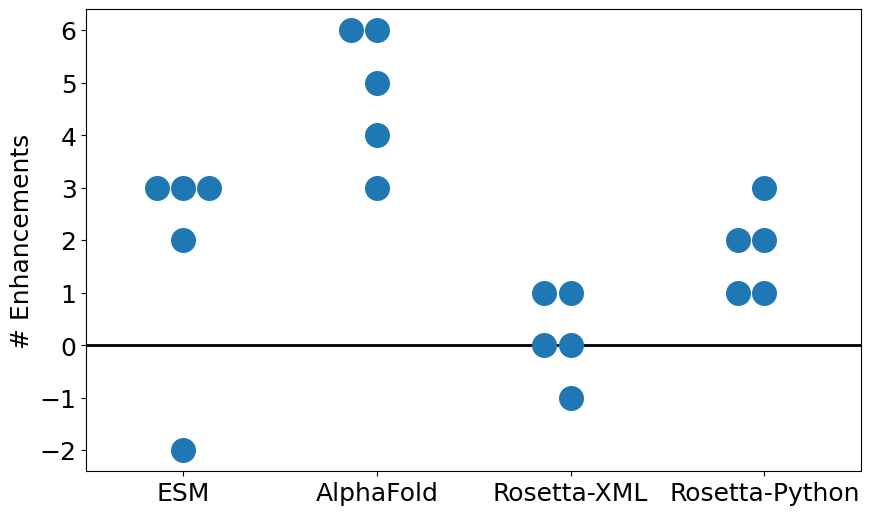

In [18]:
fontsize = 18
plt.figure(figsize=(10, 6))
plt.axhline(y=0, color='black', linestyle='-', linewidth=2)
sns.swarmplot(data=coding_eval, x='Topic', y='# Enhancements', size=18)
plt.xlabel("")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("# Enhancements", fontsize=fontsize)
plt.savefig(ablations_dir / "coding_eval.pdf", bbox_inches='tight')

## Single vs parallel meetings

To see the effect of parallel meetings, compare the individual discussions (e.g., `discussion_1.md` through `discussion_5.md`) with the result of the parallel meeting (e.g., `merged.md`) for any of the discussions in the `discussions` directory.

## Prompt engineering

Illustrate the effect of prompt engineering on tool selection. For the answer using the original agenda and agenda questions, see `discussions/tools_selection/merged.md`.

In [ ]:
# Tools selection - setup
tools_selection_prior_summaries = load_summaries(
    discussion_paths=[discussions_phase_to_dir["project_specification"] / "merged.json"])
print(f"Number of prior summaries: {len(tools_selection_prior_summaries)}")

tools_selection_dir = ablations_dir / "tools_selection"

In [4]:
# Tools selection - agendas and questions
tools_selection_agendas = [
    f"{background_prompt} {nanobody_prompt} Now you need to select machine learning and/or computational tools to implement this nanobody design approach. Please list several tools (5-10) that would be relevant to this nanobody design approach and how they could be used in the context of this project.",
    f"{background_prompt} {nanobody_prompt} Now you need to select tools to implement this nanobody design approach. Please list several tools (5-10) that would be relevant to this nanobody design approach and how they could be used in the context of this project.",
    f"{background_prompt} {nanobody_prompt} Now you need to select tools to implement this nanobody design approach. Please list several tools that would be relevant to this nanobody design approach and how they could be used in the context of this project.",
    f"{background_prompt} {nanobody_prompt} Now you need to select tools to implement this nanobody design approach. Please list several tools that would be relevant to this nanobody design approach.",
]

tools_selection_questions = [
    (
        "What machine learning and/or computational tools could be used for this nanobody design approach (list 5-10)?",
        "For each tool, how could it be used for designing modified nanobodies?",
    ),
    (
        "What tools could be used for this nanobody design approach (list 5-10)?",
        "For each tool, how could it be used for designing modified nanobodies?",
    ),
    (
        "What tools could be used for this nanobody design approach?",
        "For each tool, how could it be used for designing modified nanobodies?",
    ),
    (
        "What tools could be used for this nanobody design approach?",
    ),
]

In [ ]:
# Tools selection – ablations
for i, (agenda, agenda_questions) in enumerate(zip(tools_selection_agendas, tools_selection_questions)):
    if i != 3:
        continue

    # Create save directory
    save_dir = tools_selection_dir / f"prompt_{i + 1}"
    save_dir.mkdir(parents=True, exist_ok=True)

    # Run meetings
    with concurrent.futures.ThreadPoolExecutor() as executor:
        concurrent.futures.wait([
            executor.submit(
                run_meeting,
                meeting_type="team",
                team_lead=principal_investigator,
                team_members=team_members,
                summaries=tools_selection_prior_summaries,
                agenda=agenda,
                agenda_questions=agenda_questions,
                save_dir=save_dir,
                save_name=f"discussion_{iteration_num + 1}",
                temperature=CREATIVE_TEMPERATURE,
                num_rounds=num_rounds,
            ) for iteration_num in range(num_iterations)
        ])

    # Load summaries
    summaries = load_summaries(discussion_paths=list(save_dir.glob("discussion_*.json")))
    print(f"Number of summaries: {len(summaries)}")

    # Create merge prompt
    merge_prompt = create_merge_prompt(agenda=agenda, agenda_questions=agenda_questions)

    # Run merge meeting
    run_meeting(
        meeting_type="individual",
        team_member=principal_investigator,
        summaries=summaries,
        agenda=merge_prompt,
        save_dir=save_dir,
        save_name="merged",
        temperature=CONSISTENT_TEMPERATURE,
        num_rounds=num_rounds,
    )